ref: https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Create Signal

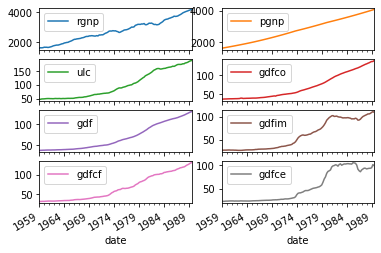

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1959-01-01,1606.4,1608.3,47.5,36.9,37.4,26.9,32.3,23.1
1959-04-01,1637.0,1622.2,47.5,37.4,37.5,27.0,32.2,23.4
1959-07-01,1629.5,1636.2,48.7,37.6,37.6,27.1,32.4,23.4
1959-10-01,1643.4,1650.3,48.8,37.7,37.8,27.1,32.5,23.8
1960-01-01,1671.6,1664.6,49.1,37.8,37.8,27.2,32.4,23.8
...,...,...,...,...,...,...,...,...
1988-07-01,4042.7,3971.9,179.6,131.5,124.9,106.2,123.5,92.8
1988-10-01,4069.4,3995.8,181.3,133.3,126.2,107.3,124.9,92.9
1989-01-01,4106.8,4019.9,184.1,134.8,127.7,109.5,126.6,94.0


In [2]:
# Create signal
filepath = 'https://raw.githubusercontent.com/selva86/datasets/master/Raotbl6.csv'
df = pd.read_csv(filepath, parse_dates=['date'], index_col='date')
df.plot(subplots=True, layout=(4, 2))
plt.show()

df

In [3]:
# Split Training and Testing Data
n = 4
df_train, df_test = df[:-n], df[-n:]

# Causality Test

In [4]:
# Causality Test

from statsmodels.tsa.stattools import grangercausalitytests
import itertools

maxlag = 12
test = "ssr_chi2test"

# create all pair variable names (Y, X)
pairs = itertools.product(df.columns, df.columns)
causation_dict = {}
for pair in pairs:
  y, x = pair[0], pair[1]

  # run causality test
  test_result = grangercausalitytests(df[[y, x]], maxlag=maxlag, verbose=False)
  # take first element of the tuple and second element of the p-value results
  pvalues = [x[0][test][1] for x in list(test_result.values())]
  min_p = min(pvalues)

  # store in dictionary
  y_str, x_str = "{}_y".format(y), "{}_x".format(x)
  if y_str not in causation_dict:
    causation_dict[y_str] = {}
  causation_dict[y_str][x_str] = min_p

# convert to dataframe
causation_matrix = pd.DataFrame(causation_dict).round(4).T
causation_matrix

,rgnp_x,pgnp_x,ulc_x,gdfco_x,gdf_x,gdfim_x,gdfcf_x,gdfce_x
rgnp_y,1.0000,0.0003,0.0001,0.0212,0.0014,0.0620,0.0001,0.0071
pgnp_y,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
ulc_y,0.0000,0.0000,1.0000,0.0002,0.0000,0.0000,0.0000,0.0041
gdfco_y,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
gdf_y,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
gdfim_y,0.0011,0.0067,0.0014,0.0083,0.0011,1.0000,0.0004,0.0000
gdfcf_y,0.0000,0.0000,0.0008,0.0008,0.0000,0.0038,1.0000,0.0009
gdfce_y,0.0025,0.0485,0.0000,0.0002,0.0000,0.0000,0.0000,1.0000


# Cointegration Test

In [13]:
# Cointegration Test
# https://www.quantstart.com/articles/Johansen-Test-for-Cointegrating-Time-Series-Analysis-in-R/

from statsmodels.tsa.vector_ar.vecm import coint_johansen

test_result = coint_johansen(df, det_order=-1, k_ar_diff=5)
# test result and significance level
test_stats, sign_levels = test_result.lr1, test_result.cvt

ranks = range(df.columns.shape[0])
for rank, test_stat, sign_level in zip(ranks, test_stats, sign_levels):
  print("Rank <= {} is {}. Test stat: {}. Significance Level: [90%] {}, [95%] {}, [99%] {}".format(rank, test_stat >= sign_level[1], round(test_stat, 4), *sign_level))

# most likely we have relationships between 6 variables since only rank <= 6 exceeds 95% significance level

Rank <= 0 is True. Test stat: 247.9955. Significance Level: [90%] 137.9954, [95%] 143.6691, [99%] 154.7977
Rank <= 1 is True. Test stat: 183.1171. Significance Level: [90%] 106.7351, [95%] 111.7797, [99%] 121.7375
Rank <= 2 is True. Test stat: 130.014. Significance Level: [90%] 79.5329, [95%] 83.9383, [99%] 92.7136
Rank <= 3 is True. Test stat: 85.2848. Significance Level: [90%] 56.2839, [95%] 60.0627, [99%] 67.6367
Rank <= 4 is True. Test stat: 55.0523. Significance Level: [90%] 37.0339, [95%] 40.1749, [99%] 46.5716
Rank <= 5 is True. Test stat: 31.5888. Significance Level: [90%] 21.7781, [95%] 24.2761, [99%] 29.5147
Rank <= 6 is True. Test stat: 14.0572. Significance Level: [90%] 10.4741, [95%] 12.3212, [99%] 16.364
Rank <= 7 is False. Test stat: 0.4513. Significance Level: [90%] 2.9762, [95%] 4.1296, [99%] 6.9406


# Test and Make Stationary

rgnp True
pgnp False
ulc True
gdfco False
gdf False
gdfim True
gdfcf False
gdfce True
1
rgnp True
pgnp True
ulc True
gdfco True
gdf True
gdfim True
gdfcf True
gdfce True
2
number of times differencing 2


[]

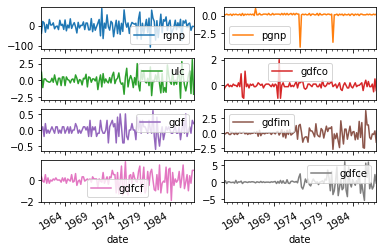

In [6]:
# ADF Test

from statsmodels.tsa.stattools import adfuller

# check if p-value is < 0.05 for all signals
def adftest(df):
  is_stationary = True
  for col in df.columns.values:
    test_result = adfuller(df[col], autolag="AIC")
    if test_result[1] > 0.05:
      is_stationary = False
    print(col, test_result[1] < 0.05)

  return is_stationary

# Make Stationary by repeated differencing
is_stationary = False
df_train_diff = df_train.copy()
count_diff = 0

while not is_stationary:
  df_train_diff = df_train_diff.diff().dropna()
  is_stationary = adftest(df_train_diff)
  count_diff += 1
  print(count_diff)
  
print("number of times differencing", count_diff)
df_train_diff.plot(subplots=True, layout=(4, 2))
plt.plot()

# Train Model

In [7]:
# Select Order(p) of VAR
model = VAR(df_train_diff)
model.select_order(maxlags=12).summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


,AIC,BIC,FPE,HQIC
0,-0.07898,0.1232,0.9241,0.002961
1,-0.5721,1.248,0.5662,0.1653
2,-0.8256,2.612,0.4482,0.5674
3,-1.007,4.048,0.3937,1.042
4,-1.255,5.418,0.3399,1.449
5,-1.230,7.060,0.4147,2.129
6,-1.739,8.169,0.3286,2.276
7,-2.142,9.384,0.3340,2.528
8,-2.964,10.18,0.2744,2.362
9,-4.562,10.20,0.1413,1.420


In [8]:
# Fit the Model
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 29, Dec, 2021
Time:                     12:57:39
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    4.37122
Nobs:                     113.000    HQIC:                  0.584936
Log likelihood:          -905.679    FPE:                   0.155570
AIC:                     -2.00074    Det(Omega_mle):       0.0200322
--------------------------------------------------------------------
Results for equation rgnp
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            2.430021         2.677505            0.908           0.364
L1.rgnp         -0.750066         0.159023           -4.717           0.000
L1.pgnp         -0.095621         4.938865           -0.019           0.985
L1.ul

# Residual Serial Correlation Test

In [9]:
# Serial Correlation Test on Residual with Durbin Watson

from statsmodels.stats.stattools import durbin_watson

test_result = durbin_watson(model_fitted.resid)

list(zip(df.columns, test_result))
# results are close to two so no serial correlation left

[('rgnp', 2.0905002468328666),
 ('pgnp', 2.020187403638321),
 ('ulc', 2.168513823361069),
 ('gdfco', 2.0472891363432253),
 ('gdf', 2.246222140826789),
 ('gdfim', 1.9931893979383049),
 ('gdfcf', 2.200943744102008),
 ('gdfce', 2.1720831193338364)]

# Forecast and Evaluate

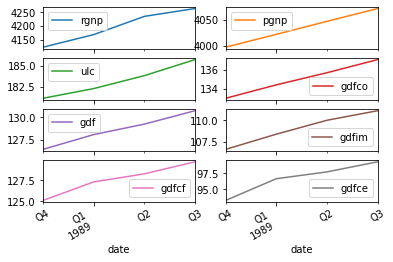

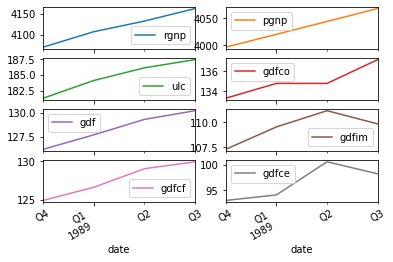

In [10]:
# Forecast and Transform Back

# input data
lag_order = model_fitted.k_ar
forecast_input = df_train_diff.values[-lag_order:]
# output data
forecast_output = model_fitted.forecast(y=forecast_input, steps=n)
diff_forecast = pd.DataFrame(forecast_output, index=df_test.index, columns=df_test.columns)

# transform back
# df_forecast = df_train.iloc[-1] + (df_train.diff().iloc[-1] + df_forecast.cumsum()).cumsum()
d2 = diff_forecast.cumsum()
d1 = (df_train.diff().iloc[-1] + d2).cumsum()
d0 = df_train.iloc[-1] + d1
df_forecast = d0

df_forecast.plot(subplots=True, layout=(4, 2))
df_test.plot(subplots=True, layout=(4, 2))
plt.show()

In [11]:
# Evaluate Forecast

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax

    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

eval_dict = {}
for col in df.columns.values:
  eval_dict[col] = forecast_accuracy(df_forecast[col], df_test[col])

eval_df = pd.DataFrame(eval_dict)
eval_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
mape,0.019171,0.000506,0.008051,0.003255,0.002254,0.009668,0.003603,0.017675
me,79.103072,2.043223,-1.494747,0.000651,0.255373,-0.416557,-0.027133,0.257750
mae,79.103072,2.043223,1.494747,0.438374,0.289995,1.060027,0.460373,1.719977
mpe,0.019171,0.000506,-0.008051,0.000002,0.001986,-0.003808,-0.000171,0.003140
rmse,82.024519,2.145959,1.685602,0.516853,0.339175,1.082613,0.528628,2.033982
corr,0.984884,0.999996,0.963010,0.940749,0.990520,0.807005,0.971340,0.763998
minmax,0.018786,0.000505,0.008051,0.003244,0.002247,0.009634,0.003595,0.017457
